# This notebook runs a global sensitivity analysis on the synaptic plasticity model
### Nathaniel Linden

In [1]:
using Statistics, DifferentialEquations, StatsPlots, DiffEqSensitivity, QuasiMonteCarlo, LaTeXStrings, Measures, Sundials
using  DataFrames, DelimitedFiles, CSV
pgfplotsx()

Plots.PGFPlotsXBackend()

In [2]:
# Function for ODE
function kinase_phos(dxdt, x, p, t)
    # Unpack parameters for clarity
    k1,k2,k3,k4,k5,k6,k7,k8,c1,c2,c3,c4,Km1,Km2,Km3,Km4,Km5,K0,P0,Ktot,Ptot,Atot = p
	pK = x[1]
    P = x[2]
    A = x[3]
    # conservation laws
#    Ktot = 20
#    Ptot = 20
#    Atot = 1
#    K0 = 0.5
#    P0 = 0.5
#     c1 = 1
#     c2 = 1
#     c3 = 6
#     c4 = 8
    K = Ktot - pK
    pP = Ptot - P
    Aint = Atot - A;
    # state dep rates for AMPAR
    k21 = c1*pK + c3
    k22 = c2*P + c4    

    # compute calcium level
    caLow = 0.1
    #caHigh = 4.0 # LTP inducing stimulus
    caHigh = 2.2 # LTD inducing stimulus
    if t > 2 && t < 4
        Ca = caHigh
    else
        Ca = caLow
    end

    # differential equations
    dxdt[1] = k1*pK*(K/(Km1 + K)) - k2*(P+P0)*(pK/(Km2+pK)) + k3*K0 + k4*K*((Ca^4)/((Km3^4) + (Ca^4)))
    dxdt[2] = k5*P*(pP/(Km4+pP)) - k6*(pK+K0)*(P/(Km5+P)) + k7*P0 + k8*pP*((Ca^3)/((Km3^3) + (Ca^3)))
    dxdt[3] = k21*Aint - k22*A
end

# function to plot the solution
# function to plot the solution
function plot_solution(y, t)
    l = @layout grid(3,1)
	pl1 = plot(t, y[1,:], ylabel=L"x_1", xlabel="Time (sec)", legend=false)
	pl2 = plot(t, y[2,:], ylabel=L"x_2", xlabel="Time (sec)", legend=false)
	pl3 = plot(t, y[3,:], ylabel=L"x_3", xlabel="Time (sec)", legend=false)
    plot(pl1,pl2,pl3,layout=l)
end

plot_solution (generic function with 1 method)

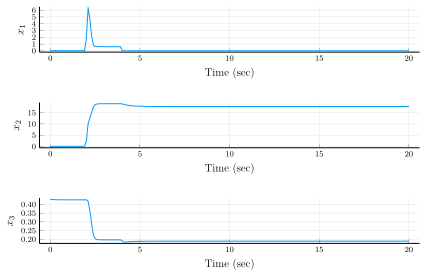

In [3]:
ptrue = [2, 15, 1, 120, 2, 15, 1, 80, 1, 1, 6, 8, 10, 0.3, 4, 10, 1, 0.5, 0.5, 20, 20, 1];
p = ptrue; # [2, 15, 1, 120, 2, 15, 1, 80, 1, 1, 6, 8, 10, 0.3, 4, 10, 1];
# x0 = [0,0,0];
x0 = [0.0228, 0.0017, 0.4294];
t0 = 0.0
tend = 20.0
tspan = (t0, tend);
prob = ODEProblem(kinase_phos,x0,tspan,p);
t = collect(range(t0, stop=tend, length=200));
y = solve(prob, AutoVern9(Rodas4()), reltol=1e-10, abstol=1e-10;saveat=t)

plot_solution(y,t)

We then want to run a global sensitivity analysis on this system. We need to define a quantity of interest (QOI) for which we wish to explore the variance due to the model parameters.

For simplicity, we consider the final steady-state values as our QOI's

This are defined as a function of the parameters to pass to the sensitivity analysis software:

In [4]:
# QOI function
function qoi(p)
  prob1 = remake(prob;p=p)
  sol = solve(prob1,alg_hints=[:stiff];saveat=t) # solve system with parameters in p
    [mean(sol[1,end-10:end]), mean(sol[2,end-10:end]), mean(sol[3,end-10:end])] 
end

function qoi_ensemble(p)
    prob_func(prob,i,repeat) = remake(prob;p=p[:,i])
    ensemble_prob = EnsembleProblem(prob,prob_func=prob_func)
    sol = solve(ensemble_prob,AutoVern9(Rodas4()), reltol=1e-10, abstol=1e-10,EnsembleThreads();saveat=t,trajectories=size(p,2))
    out = zeros(3,size(p,2))
    for i in 1:size(p,2)
        out[:,i] = [sol[i][1,end], sol[i][2,end],sol[i][3,end]/x0[3]]
    end
    out;
end

qoi_ensemble (generic function with 1 method)

Next we need to define a set of points (a sparse quadrature) to sample the QOI. This is essentially a matrix of different parameter sets to evaluate the system.

Following the tutorial at https://diffeq.sciml.ai/stable/analysis/global_sensitivity/, I will use the QuasiMonteCarlo package to generate a quadrature over the region of parameter space of interest. Here I use a SobolSequence to generate these points, but the QuasiMonteCarlo API (https://github.com/SciML/QuasiMonteCarlo.jl) has the ability to construct sets such as a LatinHyperCube set

I generate $N$ samples. The bounds of the parameter are space are chosen to be the bounds define by Nguyen et al. and those used to parameter estimation.

In [5]:
N = 5000
lb = 0.1*p;
lb[end] = x0[end];
ub = 10*p;
sampler = SobolSample()
A,B = QuasiMonteCarlo.generate_design_matrices(N,lb,ub,sampler);

Next we actually have to perform the sensitivity analysis. I chose to perform a variance based global sensitivity analysis using the Sobol method. Here I compute Total and first order sensitivity indicies (default of the method).

In [6]:
# Actually compute the sensitivity indices!
# WARNING!!! THIS IS SLOW FOR LARGE N
sobol_result = gsa(qoi_ensemble,Sobol(),A,B,batch=true)

┌ Warning: Global Sensitivity Analysis has been moved to separate package GlobalSensitivity.jl (https://github.com/SciML/GlobalSensitivity.jl)
└ @ DiffEqSensitivity /Users/natel/.julia/packages/DiffEqSensitivity/EpC0d/src/DiffEqSensitivity.jl:56


GlobalSensitivity.SobolResult{Matrix{Float64}, Nothing, Nothing, Nothing}([0.004898017637297977 0.13909350725316333 … 0.0007698937478134946 -2.8539785903071064e-16; 0.0027938716416541637 0.018610377015169186 … 0.28222658807035617 1.2546286348877473e-13; 0.006989393416983859 0.06668637120249404 … 0.014824919760819528 0.20095444118159134], nothing, nothing, nothing, [0.13656636968829342 0.4505972924381226 … 0.13702652659757772 2.016349139218593e-16; 0.025020404439544678 0.1051429348898231 … 0.5317463548451324 -5.53415666959423e-15; 0.060845162989452244 0.22705576404240702 … 0.19637897570398583 0.4141430862291882], nothing)

Now we can plot the sensitivity indices to get a sense of how the different parameter contribute to the variance in the mean and std of the various states

In [7]:
xlabs = ["k_1", "k_2", "k_3", "k_4", "k_5", "k_6","k_7", "k_8","c_1","c_2","c_3","c_4",
   "K_{m1}","K_{m2}","K_{m3}","K_{m4}","K_{m5}", "K_0", "P_0", "K_{tot}", "P_{tot}", "A_{tot}"]
xtik = 1:23;

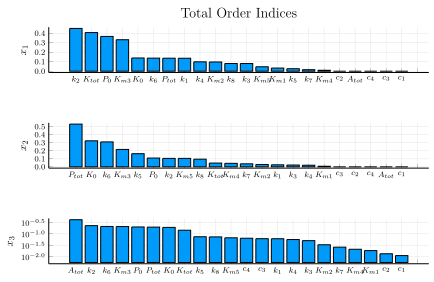

In [8]:
x1perm = sortperm(broadcast(abs, sobol_result.ST[1,:]), rev=true);
x2perm = sortperm(broadcast(abs, sobol_result.ST[2,:]), rev=true);
x3perm = sortperm(broadcast(abs, sobol_result.ST[3,:]), rev=true);
    
l = @layout grid(3,1)
pl1 = bar(sobol_result.ST[1,x1perm],title="Total Order Indices",legend=false, xticks=(xtik, xlabs[x1perm]), ylabel=L"x_1")
pl2 = bar(sobol_result.ST[2,x2perm],legend=false, xticks=(xtik, xlabs[x2perm]), ylabel=L"x_2")
pl3 = bar(sobol_result.ST[3,x3perm],legend=false, xticks=(xtik, xlabs[x3perm]), ylabel=L"x_3", yscale=:log10)
plot(pl1,pl2,pl3, layout=l)

# Uncomment to save for LTP/LTD
# savefig("../../results/kinase_phosphatase/sensitivity_analysis/LTP_End_total_order.pdf")
#savefig("../../results/kinase_phosphatase/sensitivity_analysis/LTD_End_total_order.pdf")

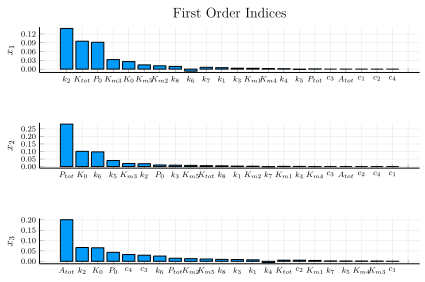

In [9]:
x1perm = sortperm(broadcast(abs, sobol_result.S1[1,:]), rev=true);
x2perm = sortperm(broadcast(abs, sobol_result.S1[2,:]), rev=true);
x3perm = sortperm(broadcast(abs, sobol_result.S1[3,:]), rev=true);

l = @layout  grid(3,1)
pl1 = bar(sobol_result.S1[1,x1perm],title="First Order Indices",legend=false, xticks=(xtik, xlabs[x1perm]), ylabel=L"x_1")
pl2 = bar(sobol_result.S1[2,x2perm],legend=false, xticks=(xtik, xlabs[x2perm]), ylabel=L"x_2")
pl3 = bar(sobol_result.S1[3,x3perm],legend=false, xticks=(xtik, xlabs[x3perm]), ylabel=L"x_3")
plot(pl1,pl2,pl3, layout=l)

# Uncomment to save for LTP/LTD
# savefig("../../results/kinase_phosphatase/sensitivity_analysis/LTP_End_first_order.pdf")
#savefig("../../results/kinase_phosphatase/sensitivity_analysis/LTD_End_first_order.pdf")

In [10]:
x = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22];
df_x1 = DataFrame(idx=x, sobol=sobol_result.S1[1,x1perm], label=xlabs[x1perm]);
df_x2 = DataFrame(idx=x, sobol=sobol_result.S1[2,x2perm], label=xlabs[x2perm]);
df_x3 = DataFrame(idx=x, sobol=sobol_result.S1[3,x3perm], label=xlabs[x3perm]);

# CSV.write("../../results/kinase_phosphatase/sensitivity_analysis/firstorder_x1.csv", df_x1);
# CSV.write("../../results/kinase_phosphatase/sensitivity_analysis/firstorder_x2.csv", df_x2);
# CSV.write("../../results/kinase_phosphatase/sensitivity_analysis/firstorder_x3.csv", df_x3);

CSV.write("../../results/kinase_phosphatase/sensitivity_analysis/LTD_firstorder_x1.csv", df_x1);
CSV.write("../../results/kinase_phosphatase/sensitivity_analysis/LTD_firstorder_x2.csv", df_x2);
CSV.write("../../results/kinase_phosphatase/sensitivity_analysis/LTD_firstorder_x3.csv", df_x3);

In [11]:
x1perm = sortperm(broadcast(abs, sobol_result.ST[1,:]), rev=true);
x2perm = sortperm(broadcast(abs, sobol_result.ST[2,:]), rev=true);
x3perm = sortperm(broadcast(abs, sobol_result.ST[3,:]), rev=true);

df_x1 = DataFrame(idx=x, sobol=sobol_result.ST[1,x1perm], label=xlabs[x1perm]);
df_x2 = DataFrame(idx=x, sobol=sobol_result.ST[2,x2perm], label=xlabs[x2perm]);
df_x3 = DataFrame(idx=x, sobol=sobol_result.ST[3,x3perm], label=xlabs[x3perm]);


# CSV.write("../../results/kinase_phosphatase/sensitivity_analysis/totalorder_x1.csv", df_x1);
# CSV.write("../../results/kinase_phosphatase/sensitivity_analysis/totalorder_x2.csv", df_x2);
# CSV.write("../../results/kinase_phosphatase/sensitivity_analysis/totalorder_x3.csv", df_x3);

CSV.write("../../results/kinase_phosphatase/sensitivity_analysis/LTD_totalorder_x1.csv", df_x1);
CSV.write("../../results/kinase_phosphatase/sensitivity_analysis/LTD_totalorder_x2.csv", df_x2);
CSV.write("../../results/kinase_phosphatase/sensitivity_analysis/LTD_totalorder_x3.csv", df_x3);